# Captum Tutorial

## Getting Started

In [1]:
import torch

import numpy as np
import torch.nn as nn

from captum.attr import IntegratedGradients

In [2]:
class ToyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(3,3)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(3,2)
        
        self.lin1.weight = nn.Parameter(torch.arange(-4.0, 5.0).view(3,3))
        self.lin1.bias = nn.Parameter(torch.zeros(3))
        
        self.lin2.weight = nn.Parameter(torch.arange(-3.0, 3.0).view(2,3))
        self.lin2.bias = nn.Parameter(torch.ones(2))
        
    def forward(self, input):
        return self.lin2(self.relu(self.lin1(input)))
    
model = ToyModel()
model.eval()

ToyModel(
  (lin1): Linear(in_features=3, out_features=3, bias=True)
  (relu): ReLU()
  (lin2): Linear(in_features=3, out_features=2, bias=True)
)

In [3]:
torch.manual_seed(123)
np.random.seed(123)

In [4]:
input = torch.randn(2,3)
baseline = torch.zeros(2,3)

In [5]:
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(input, baseline, target=0, return_convergence_delta=True)
print('IG attributions:', attributions)
print('Convergence Delta:', delta)

IG attributions: tensor([[ -1.3376,   1.0833,  -2.2178],
        [ -3.3659, -10.7723,   0.8371]], dtype=torch.float64)
Convergence Delta: tensor([9.6858e-08, 9.2387e-07], dtype=torch.float64)


## Getting Started with Captum - Titanic Data Analysis

## Summary:
* Feature Importance Across Network
    * Integrated Gradients
* Neuron Importance Within a Layer
    * Layer Conductance, with it:
        * Neuron average conductance over data set 
        * Neuron conductance distribution over data set
* Feature Importance Within Neuron
    * Neuron Conductance, with it:
        * Average Feature Importance

In [6]:
import numpy as np

import torch

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

In [7]:
titanic_data = pd.read_csv('titanic3.csv')
titanic_data.head(1)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"


In [8]:
titanic_data = pd.concat([titanic_data,
    pd.get_dummies(titanic_data['sex']),
    pd.get_dummies(titanic_data['embarked'],prefix="embark"),
    pd.get_dummies(titanic_data['pclass'],prefix="class")], axis=1
    )
titanic_data["age"] = titanic_data["age"].fillna(titanic_data["age"].mean())
titanic_data["fare"] = titanic_data["fare"].fillna(titanic_data["fare"].mean())
titanic_data = titanic_data.drop(['name','ticket','cabin','boat','body','home.dest','sex','embarked','pclass'], axis=1)


In [9]:
titanic_data

,survived,age,sibsp,parch,fare,female,male,embark_C,embark_Q,embark_S,class_1,class_2,class_3
0,1,29.000000,0,0,211.3375,True,False,False,False,True,True,False,False
1,1,0.920000,1,2,151.5500,False,True,False,False,True,True,False,False
2,0,2.000000,1,2,151.5500,True,False,False,False,True,True,False,False
3,0,30.000000,1,2,151.5500,False,True,False,False,True,True,False,False
4,0,25.000000,1,2,151.5500,True,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,14.500000,1,0,14.4542,True,False,True,False,False,False,False,True
1305,0,29.881138,1,0,14.4542,True,False,True,False,False,False,False,True
1306,0,26.500000,0,0,7.2250,False,True,True,False,False,False,False,True
1307,0,27.000000,0,0,7.2250,False,True,True,False,False,False,False,True


In [10]:
# Set random seed for reproducibility.
np.random.seed(131254)

# Convert features and labels to numpy arrays.
labels = titanic_data["survived"].to_numpy()
titanic_data = titanic_data.drop(['survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

# Separate training and test sets using 
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

In [11]:
import torch 
import torch.nn as nn
torch.manual_seed(1)

class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

In [12]:
# To rectify an error message
train_features = train_features.astype(float)

In [13]:
net = TitanicSimpleNNModel()
USE_PRETRAINED_MODEL = False

if USE_PRETRAINED_MODEL:
    net.load_state_dict(torch.load('titanic_model.pt'))
    print("Model Loaded!")
    input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
    label_tensor = torch.from_numpy(train_labels)
else:
    criterion = nn.CrossEntropyLoss()
    num_epochs = 200

    optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
    input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
    label_tensor = torch.from_numpy(train_labels)
    for epoch in range(num_epochs):    
        output = net(input_tensor)
        loss = criterion(output, label_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))

    torch.save(net.state_dict(), 'titanic_model.pt')

Epoch 1/200 => Loss: 0.70
Epoch 21/200 => Loss: 0.55
Epoch 41/200 => Loss: 0.50
Epoch 61/200 => Loss: 0.49
Epoch 81/200 => Loss: 0.48
Epoch 101/200 => Loss: 0.49
Epoch 121/200 => Loss: 0.49
Epoch 141/200 => Loss: 0.50
Epoch 161/200 => Loss: 0.49
Epoch 181/200 => Loss: 0.48


In [14]:
net.state_dict().keys()

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])

In [15]:
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels)/len(train_labels))

Train Accuracy: 0.8373362445414847


In [16]:
# To rectify an error message
test_features = test_features.astype(float)

In [17]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels)/len(test_labels))

Test Accuracy: 0.7989821882951654


# Feature Attribution with Integrated Gradients

In [18]:
ig = IntegratedGradients(net)

In [19]:
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor, target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

Average Feature Importances
age : -0.23962253251760476
sibsp : -0.07359846474606306
parch : 0.006302437175251254
fare : -0.1548895492290115
female : 0.10200280137336583
male : -0.3586633840372338
embark_C : 0.08070377298200414
embark_Q : 0.017623312584027037
embark_S : -0.0771791854581359
class_1 : 0.09776810317659355
class_2 : 0.00017152220564392486
class_3 : -0.1151045127908786


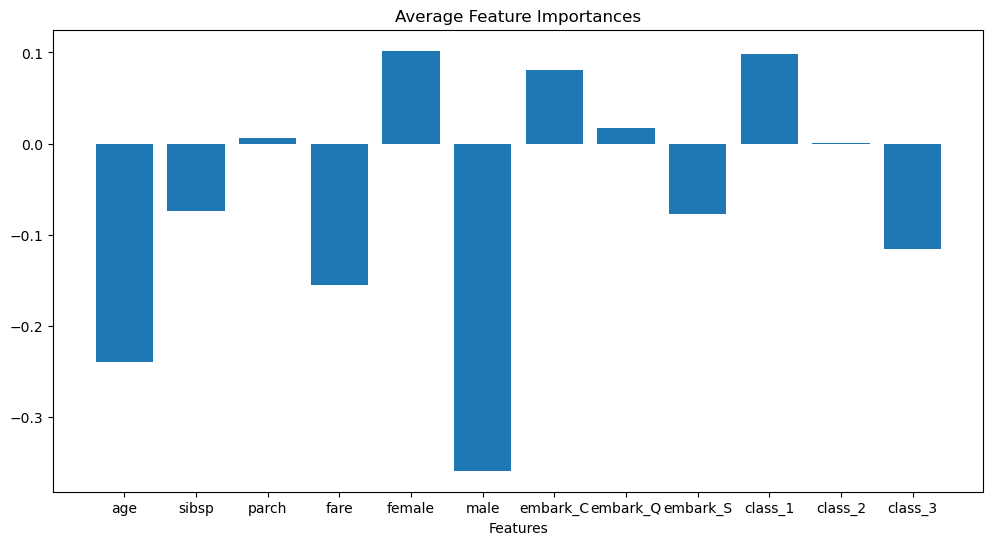

In [20]:
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ':', importances[i])
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

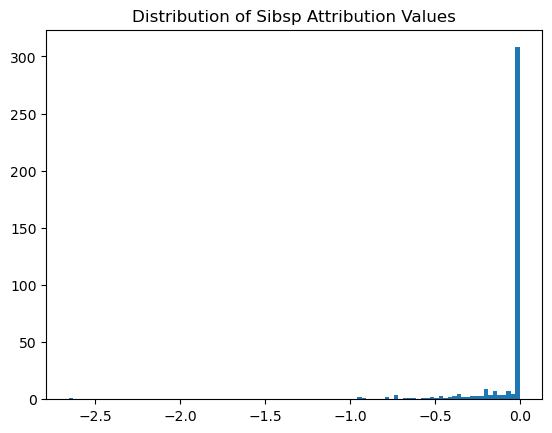

In [21]:
plt.hist(attr[:,1], 100);
plt.title("Distribution of Sibsp Attribution Values");

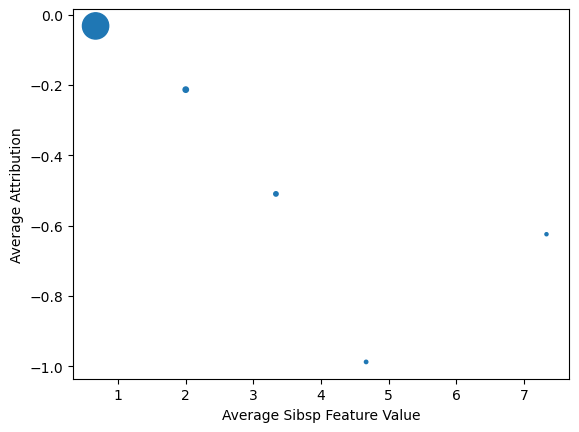

In [22]:
bin_means, bin_edges, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='mean', bins=6)
bin_count, _, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='count', bins=6)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.scatter(bin_centers, bin_means, s=bin_count)
plt.xlabel("Average Sibsp Feature Value");
plt.ylabel("Average Attribution");

# Layer Attribution with Layer Conductance

In [76]:
cond = LayerConductance(net, net.sigmoid1)

cond_linear1 = LayerConductance(net, net.linear1)
cond_sigmoid1 = LayerConductance(net, net.sigmoid1)
cond_linear2 = LayerConductance(net, net.linear2)
cond_sigmoid2 = LayerConductance(net, net.sigmoid2)
cond_linear3 = LayerConductance(net, net.linear3)
cond_softmax = LayerConductance(net, net.softmax)

In [48]:
cond_vals = cond.attribute(test_input_tensor, target=1)
cond_vals = cond_vals.detach().numpy()

In [62]:
# If I want to visualize each layer
# Though I'm not sure if this is appropriate with the target=1.  TODO: find out
cond_linear1_vals = cond_linear1.attribute(test_input_tensor, target=1)
cond_linear1_vals = cond_linear1_vals.detach().numpy()

cond_sigmoid1_vals = cond_sigmoid1.attribute(test_input_tensor, target=1)
cond_sigmoid1_vals = cond_sigmoid1_vals.detach().numpy()

cond_linear2_vals = cond_linear2.attribute(test_input_tensor, target=1)
cond_linear2_vals = cond_linear2_vals.detach().numpy()

cond_sigmoid2_vals = cond_sigmoid2.attribute(test_input_tensor, target=1)
cond_sigmoid2_vals = cond_sigmoid2_vals.detach().numpy()

cond_linear3_vals = cond_linear3.attribute(test_input_tensor, target=1)
cond_linear3_vals = cond_linear3_vals.detach().numpy()

cond_softmax_vals = cond_softmax.attribute(test_input_tensor, target=1)
cond_softmax_vals = cond_softmax_vals.detach().numpy()

layer_cond_vals_dict = [cond_linear1_vals,
                        cond_sigmoid1_vals,
                        cond_linear2_vals,
                        cond_sigmoid2_vals,
                        cond_linear3_vals,
                        cond_softmax_vals
                        ]

In [56]:
def visualize_layer(layer_cond_vals):
    visualize_importances(range(layer_cond_vals.shape[1]), np.mean(layer_cond_vals,axis=0), title="Average Neuron Importances", axis_title='Neurons')

Average Neuron Importances
0 : 0.0016929631
1 : -0.46175992
2 : 0.013216644
3 : 0.006012628
4 : 0.015149067
5 : 0.03908808
6 : 0.014632999
7 : 0.0001247628
8 : -0.06289039
9 : -7.8488265e-05
10 : -0.2829379
11 : 0.0069856164


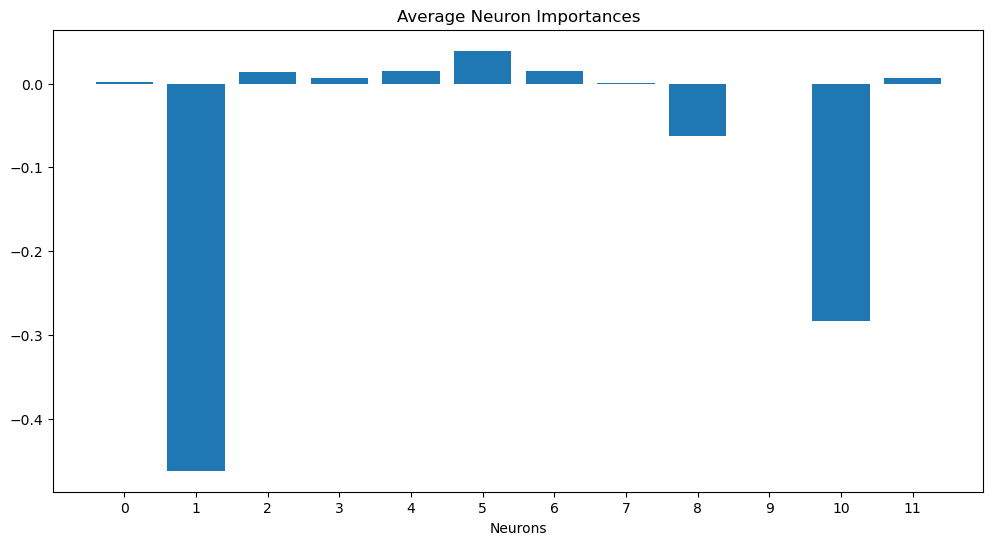

In [73]:
visualize_layer(cond_vals)

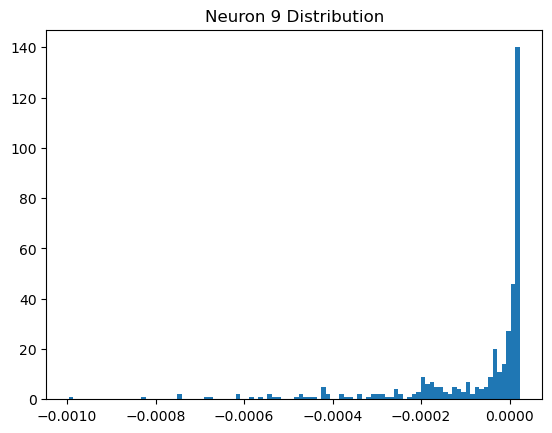

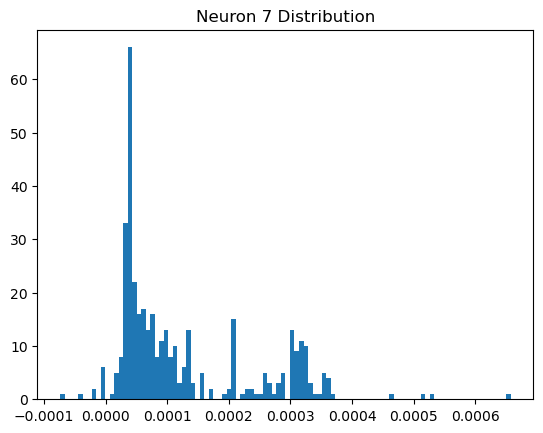

In [74]:
plt.hist(cond_vals[:,9], 100);
plt.title("Neuron 9 Distribution")
plt.figure()
plt.hist(cond_vals[:,7], 100);
plt.title("Neuron 7 Distribution");

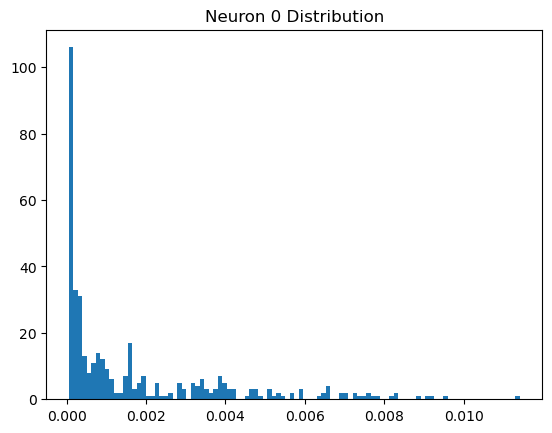

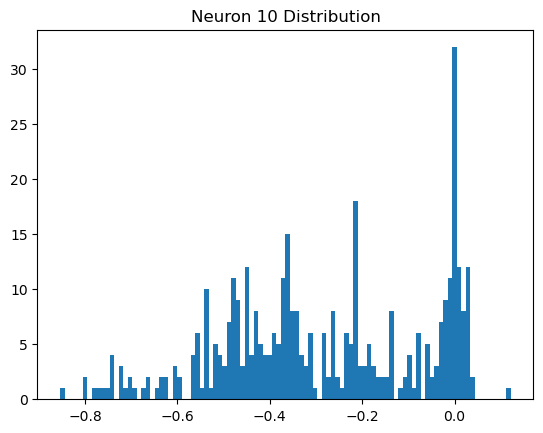

In [75]:
plt.hist(cond_vals[:,0], 100);
plt.title("Neuron 0 Distribution")
plt.figure()
plt.hist(cond_vals[:,10], 100);
plt.title("Neuron 10 Distribution");

# Neuron Attribution with Neuron Conductance

In [78]:
neuron_cond = NeuronConductance(net, net.sigmoid1)

In [84]:
neuron_cond_vals_0 = neuron_cond.attribute(test_input_tensor, neuron_selector=0, target=1)
neuron_cond_vals_10 = neuron_cond.attribute(test_input_tensor, neuron_selector=10, target=1)

In [92]:
def visualize_neuron(i):
    neuron_cond_vals = neuron_cond.attribute(test_input_tensor, neuron_selector=i, target=1)
    visualize_importances(feature_names, neuron_cond_vals.mean(dim=0).detach().numpy(), title=f"Average Feature Importances for Neuron {i}")

Average Feature Importances for Neuron 0
age : 0.0012253118
sibsp : 4.800829e-06
parch : 4.6790665e-06
fare : 0.00067231414
female : 2.1723674e-06
male : -3.8412694e-05
embark_C : 2.8567067e-06
embark_Q : 4.6210694e-06
embark_S : 5.4858592e-05
class_1 : 9.1384555e-07
class_2 : 5.0036247e-06
class_3 : 2.5628331e-05


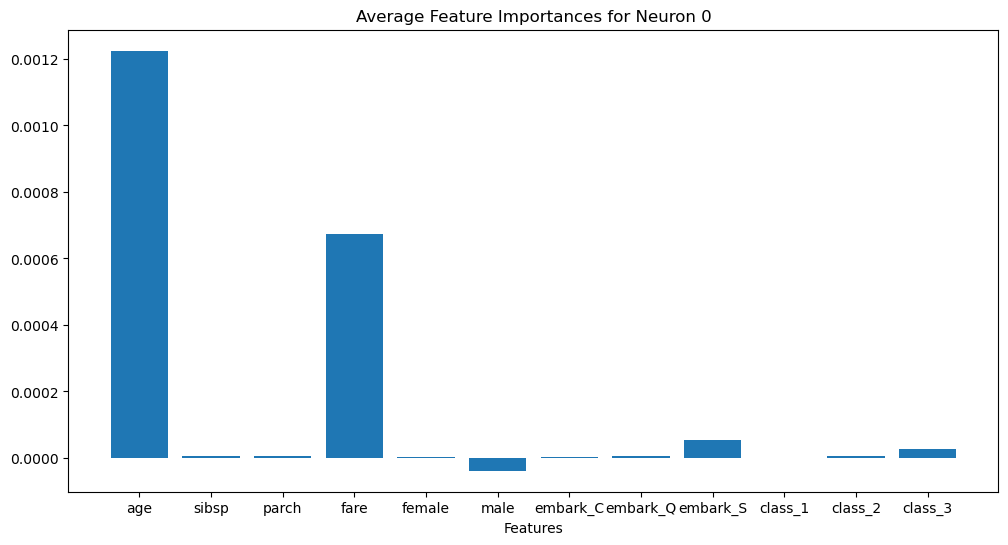

In [95]:
# visualize_importances(feature_names, neuron_cond_vals_0.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 0")
visualize_neuron(0)

# Consolidate

# Experiment with DistilBert

In [98]:
from transformers import DistilBertTokenizer, DistilBertModel

In [99]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

outputs

In [100]:
model.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li